
The notebook covers Following Topics

- Missing Value Analysis
- Correlation Analysis
- Top Contributing Features (Through XGBoost)
- PCA

Data is not consistently used as file intended as test has been temporarily withdrawn,changes will be made as soon
as it's available.'

In [1]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
from scipy.stats import kendalltau
import missingno as msno
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import warnings
matplotlib.style.use("ggplot")
#pd.options.mode.changed_assignment = None
#warnings.filterwarnings("ignore")
%matplotlib inline

Reading In Dataset
training file and property for 2016. Will be merging the two to create an efficient document to test errors on

In [3]:
train = pd.read_csv("train_2016_v2.csv", parse_dates=["transactiondate"])

In [4]:
train.columns

Index(['parcelid', 'logerror', 'transactiondate'], dtype='object')

In [2]:
properties = pd.read_csv("properties_2016.csv", low_memory = True)

c:\users\monika\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
properties.columns

Index(['parcelid', 'airconditioningtypeid', 'architecturalstyletypeid',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildin

Shape of Dataset

In [6]:
print ('shape of training set: ', train.shape)
print ('shape of properties dataframe: ', properties.shape)

shape of training set:  (90275, 3)
shape of properties dataframe:  (2985217, 58)


Merge 'Train' and 'Properties' for EDA

In [7]:
merged = pd.merge(train,properties,on="parcelid",how="left")

In [8]:
print ('shape of merged: ', merged.shape)

shape of merged:  (90275, 60)


In [9]:
merged.head(4).transpose()

,0,1,2,3
parcelid,11016594,14366692,12098116,12643413
logerror,0.0276,-0.1684,-0.004,0.0218
transactiondate,2016-01-01 00:00:00,2016-01-01 00:00:00,2016-01-01 00:00:00,2016-01-02 00:00:00
airconditioningtypeid,1,NaN,1,1
architecturalstyletypeid,NaN,NaN,NaN,NaN
basementsqft,NaN,NaN,NaN,NaN
bathroomcnt,2,3.5,3,2
bedroomcnt,3,4,2,2
buildingclasstypeid,NaN,NaN,NaN,NaN
buildingqualitytypeid,4,NaN,4,4


Visualising Datatypes

In [22]:
pd.DataFrame(merged.dtypes.value_counts()).reset_index().rename(columns={"index":"Variable Type", 0:"Count"})

,Variable Type,Count
0,object,58
1,float64,1
2,datetime64[ns],1


In [9]:
dataType = pd.DataFrame(merged.dtypes.value_counts()).reset_index().rename(columns={"index":"Variable Type", 0:"Count"})

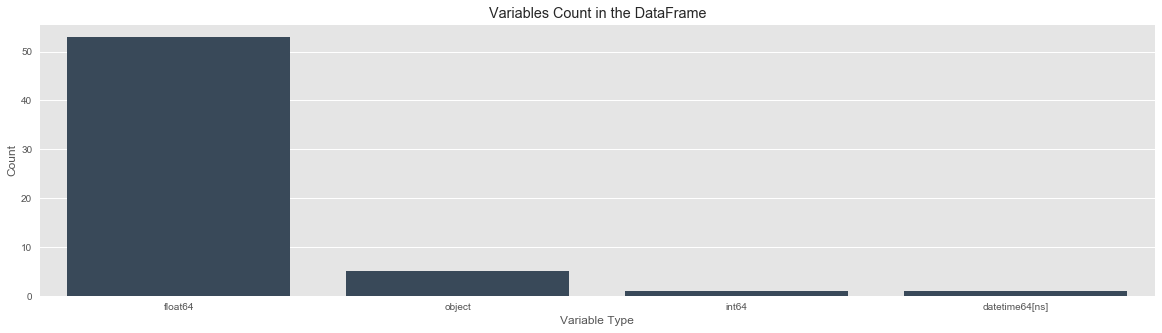

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
sn.barplot(data=dataType, x = "Variable Type", y = "Count", ax = ax, color="#34495e")
ax.set(xlabel = "Variable Type", ylabel = "Count", title = "Variables Count in the DataFrame")

Missing Value Analysis

In [11]:
### Calculate number of missing values per column
missingValueColumns = merged.columns[merged.isnull().any()].tolist()

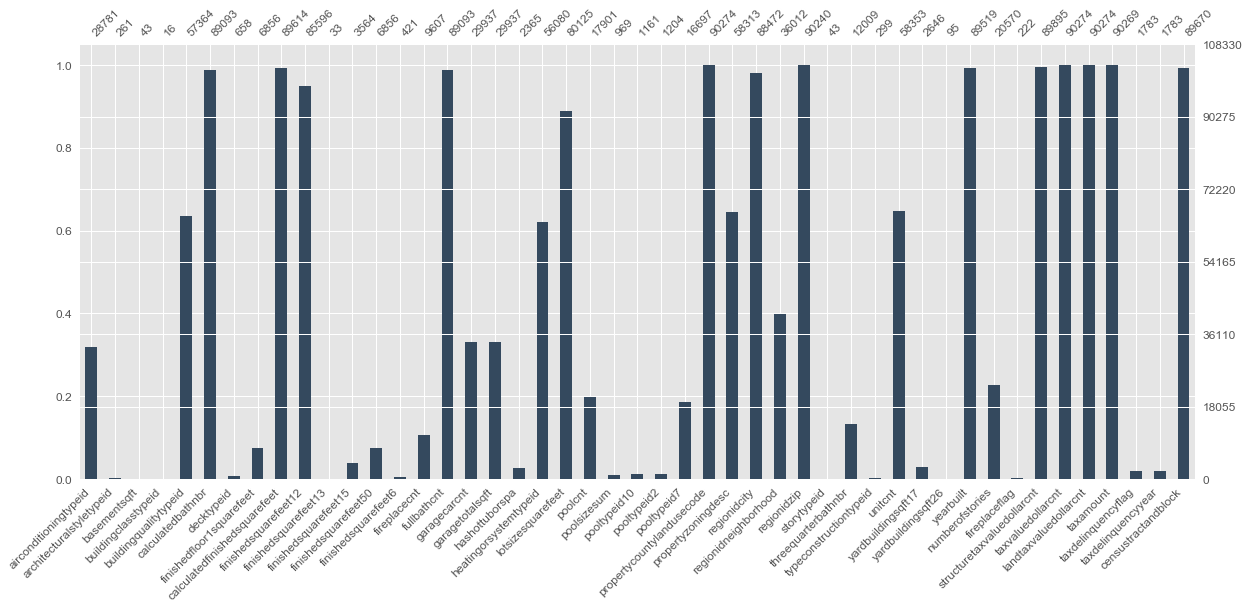

In [12]:
### Right hand axis shows value figure, minor axis by 18,055
### Count showing missing values by column
msno.bar(merged[missingValueColumns], figsize=(20,8),color="#34495e",fontsize=12,labels=True,)

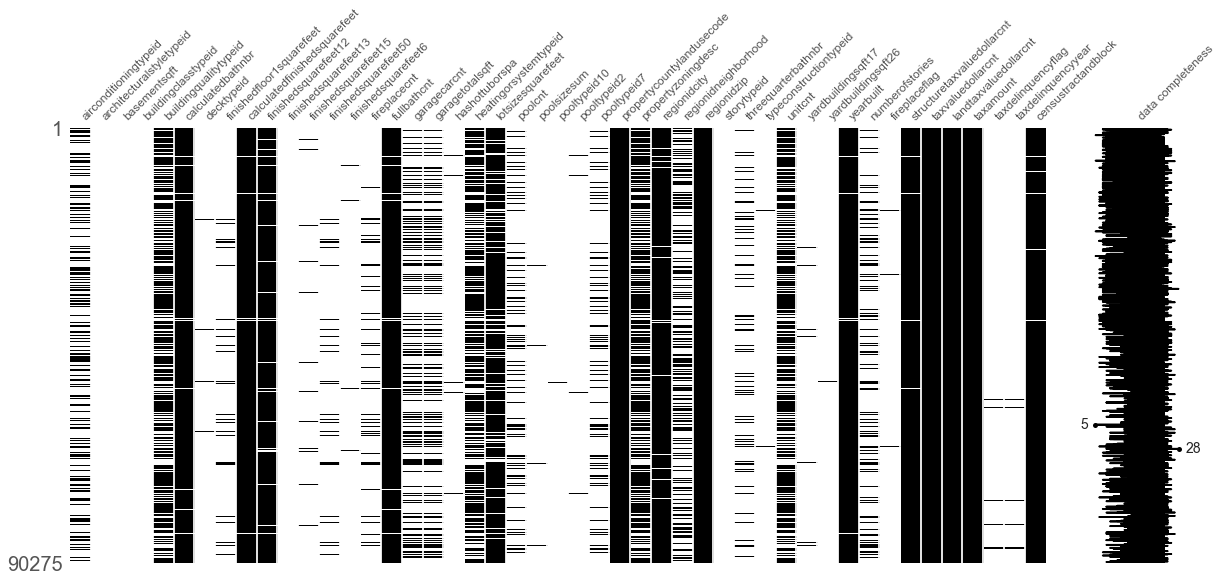

In [13]:
### Missing data demonstrated by column density
msno.matrix(merged[missingValueColumns],width_ratios=(10,1),\
            figsize=(20,8),color=(0,0, 0),fontsize=12,sparkline=True,labels=True)

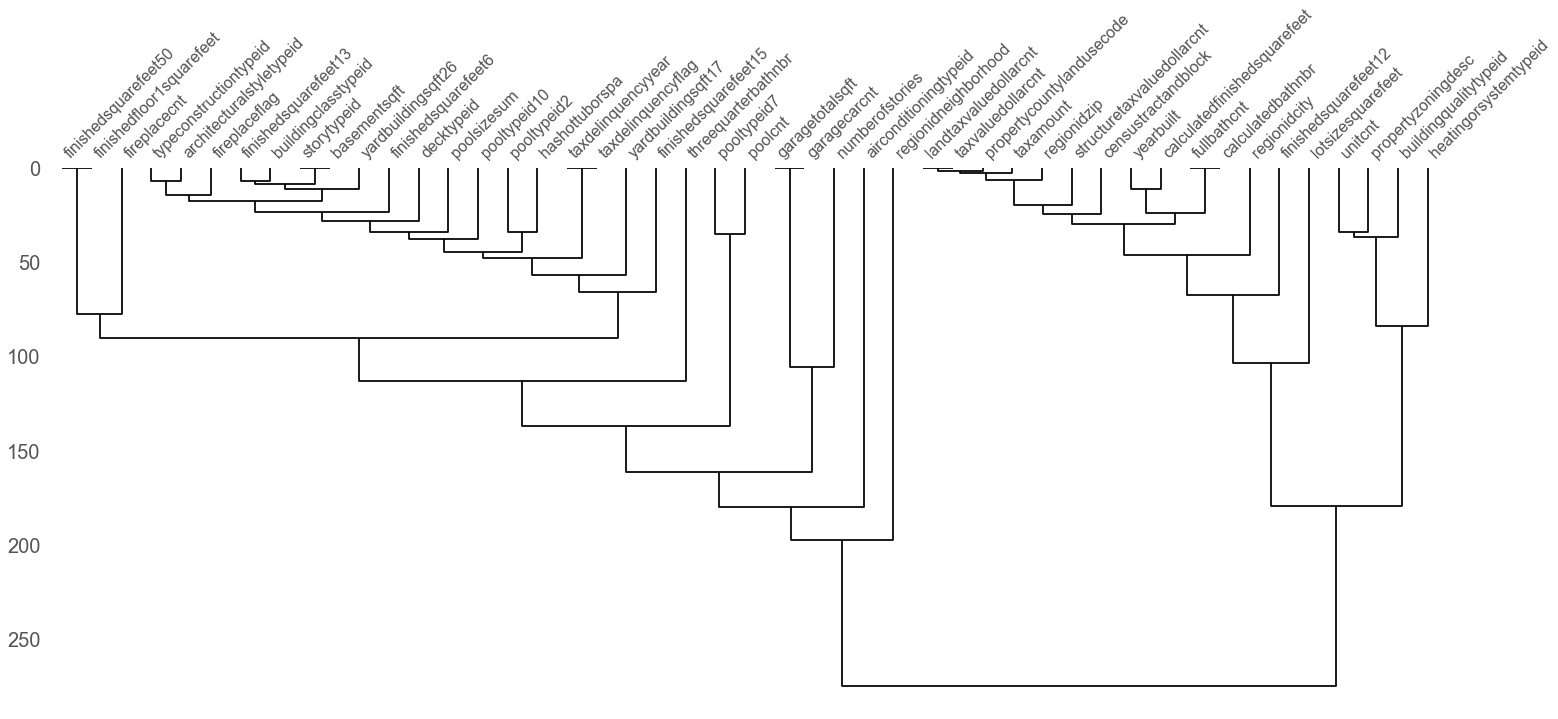

In [14]:
### Shows taxonomic relationships:
msno.dendrogram(merged[missingValueColumns])

### Top Features Selection

### Under Construction, xgboost parameters are being calculated

In [15]:
from sklearn import model_selection, preprocessing
import xgboost as xgb
import warnings
#warnings.filterwarnings("ignore")

c:\users\monika\appdata\local\programs\python\python36\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [16]:
### Have set 'NaN' values to 0. I'm choosing this "naive" option because average per dimension is not representative.
filteredMerged = merged.fillna(value=0)

In [17]:
### Values with datatype 'object' are given a numeric value
for f in filteredMerged.columns:
    if filteredMerged[f].dtype == 'object':
        processed = preprocessing.LabelEncoder()
        processed.fit(list(filteredMerged[f].values))
        filteredMerged[f] = processed.transform(list(filteredMerged[f].values))

In [18]:
### Train to predict logerror values. "logerror" is label for y, drop ID, date and logerror columns for X.
trainY = filteredMerged.logerror.values
trainX = filteredMerged.drop(["parcelid", "transactiondate", "logerror"], axis=1)

In [57]:
### Dictionary created for xgboost model. 
### 'eta': learning rate; subsample/colsample_bytree/colsample_bylevel: 80% random sampling
xgbParams = {'eta': 0.05,'max_depth': 6,'subsample': 0.2,'colsample_bytree': 0.2,'colsample_bylevel':0.2,
             'objective': 'reg:linear','eval_metric': 'rmse','silent': 1}

In [58]:
dtrain = xgb.DMatrix(trainX, trainY, feature_names=trainX.columns.values)
model = xgb.train(dict(xgbParams, silent=0), dtrain, num_boost_round=500)

In [59]:
### Get score for each dimension in terms of importance
featureImportance = model.get_fscore()
featureImportance

{'airconditioningtypeid': 146,
 'architecturalstyletypeid': 36,
 'basementsqft': 38,
 'bathroomcnt': 413,
 'bedroomcnt': 216,
 'buildingclasstypeid': 43,
 'buildingqualitytypeid': 207,
 'calculatedbathnbr': 331,
 'calculatedfinishedsquarefeet': 447,
 'censustractandblock': 341,
 'decktypeid': 33,
 'finishedfloor1squarefeet': 126,
 'finishedsquarefeet12': 353,
 'finishedsquarefeet13': 55,
 'finishedsquarefeet15': 204,
 'finishedsquarefeet50': 141,
 'finishedsquarefeet6': 125,
 'fips': 127,
 'fireplacecnt': 177,
 'fireplaceflag': 24,
 'fullbathcnt': 348,
 'garagecarcnt': 161,
 'garagetotalsqft': 311,
 'hashottuborspa': 58,
 'heatingorsystemtypeid': 117,
 'landtaxvaluedollarcnt': 434,
 'latitude': 432,
 'longitude': 321,
 'lotsizesquarefeet': 457,
 'numberofstories': 106,
 'poolcnt': 73,
 'poolsizesum': 91,
 'pooltypeid10': 62,
 'pooltypeid2': 59,
 'pooltypeid7': 85,
 'propertycountylandusecode': 274,
 'propertylandusetypeid': 209,
 'propertyzoningdesc': 340,
 'rawcensustractandblock': 34

In [60]:
### Create a Data Frame called features. "featureImportance" dictionary keys and values make up the Frame.
### Values in Data Frame sorted by 'importance' (values) in ascending order.
features = pd.DataFrame()
features['features'] = featureImportance.keys()
features['importance'] = featureImportance.values()
features.sort_values(by=['importance'],ascending=False,inplace=True)

In [61]:
### Demonstrate that sorting has worked.
features.head(15)

,features,importance
7,taxvaluedollarcnt,499
24,lotsizesquarefeet,457
21,calculatedfinishedsquarefeet,447
18,landtaxvaluedollarcnt,434
13,latitude,432
35,taxamount,416
22,bathroomcnt,413
25,yearbuilt,408
3,structuretaxvaluedollarcnt,402
14,regionidzip,362


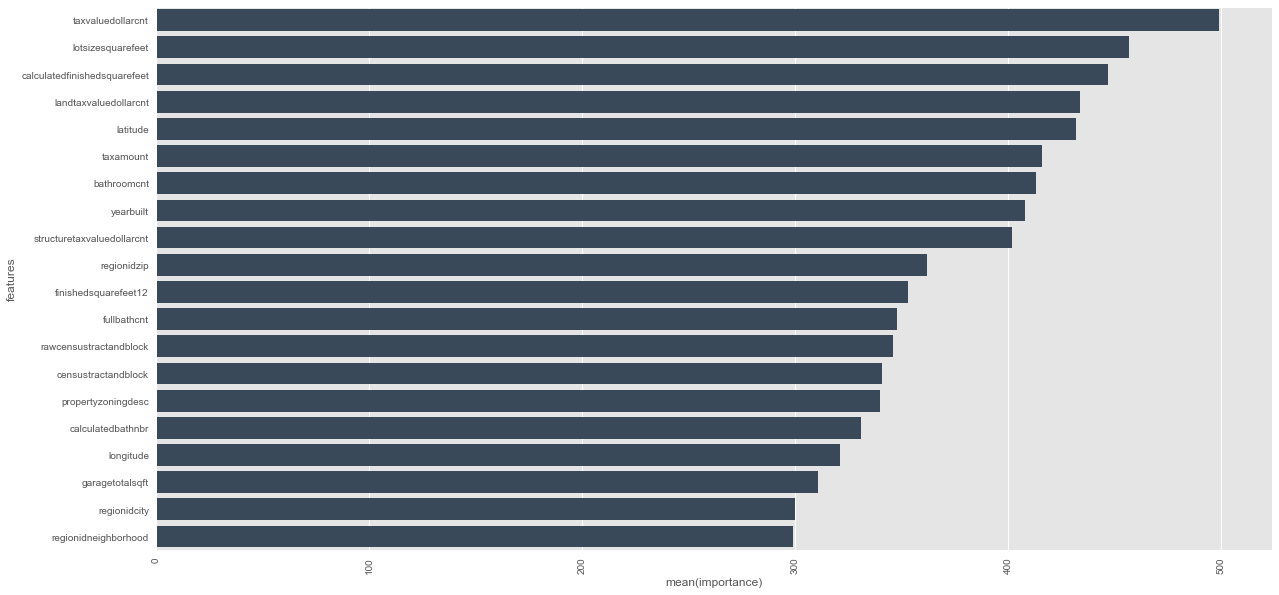

In [62]:
### Graphic representation of the top 15 features above.
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
plt.xticks(rotation=90)
sn.barplot(data=features.head(20),x="importance",y="features",ax=ax,orient="h",color="#34495e")

######################################################################

### Correlation Analysis with Heatmap

In [42]:
### Again, top 15 features
features["features"].tolist()[:15]

['calculatedfinishedsquarefeet',
 'latitude',
 'lotsizesquarefeet',
 'structuretaxvaluedollarcnt',
 'taxamount',
 'longitude',
 'taxvaluedollarcnt',
 'bathroomcnt',
 'rawcensustractandblock',
 'landtaxvaluedollarcnt',
 'yearbuilt',
 'bedroomcnt',
 'finishedsquarefeet12',
 'regionidzip',
 'propertyzoningdesc']

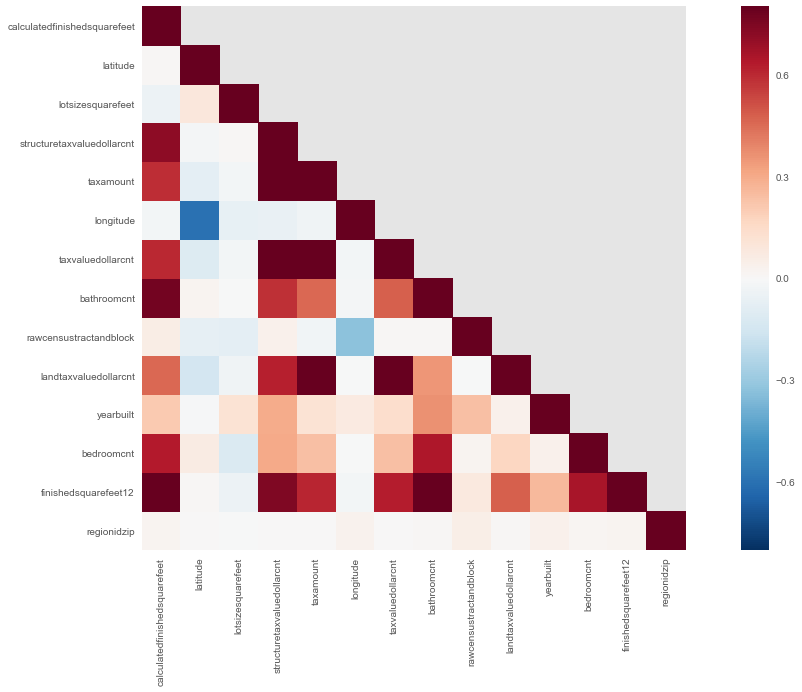

In [43]:
topFeatures = features["features"].tolist()[:15]
corrMatt = merged[topFeatures].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True)

You can detect high-multi-collinearity by inspecting the eigen values of correlation matrix. 
A very low eigen value shows that the data are collinear, and the corresponding eigen vector shows which 
variables are collinear.
accepted
If there is no collinearity in the data, you would expect that none of the eigen values are close to zero:


each eigen vector explains the variation in the data orthogonal to other eigen vectors, and the eigen value shows 
how much variation is in that direction. 
An almost zero eigen value shows a direction with zero variation, hence collinearity

### PCA

In [44]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

In [45]:
### Train to predict logerror values

trainY = filteredMerged.logerror.values
trainX = filteredMerged.drop(["parcelid", "transactiondate", "logerror"], axis=1)

In [46]:
X, y = filteredMerged.drop(["parcelid", "transactiondate", "logerror"], axis=1), filteredMerged.logerror.values

In [47]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.1, random_state=0)

In [48]:
print (Xtrain.shape)
print (ytrain.shape)
print (Xtest.shape)
print (ytest.shape)

(81247, 57)
(81247,)
(9028, 57)
(9028,)


In [49]:
sc = StandardScaler()

In [50]:
Xtrain_std = sc.fit_transform(Xtrain)
Xtest_std = sc.transform(Xtest)

Constructing the covariance matrix
- using linalg.eig function to obtain eigenpairs

In [51]:
### Covariance Matrix in numpy, created by Standard Scaler processed training data
covMatrix = np.cov(Xtrain_std.T)

In [52]:
### Eigenvalues and eigenvectors for PCA calculation are created by using numpy linear algebra function.
eigenValues, eigenVectors = np.linalg.eig(covMatrix)

In [53]:
print("\nEigenvalues \n%s" % eigenValues)


Eigenvalues 
[  9.63796823e+00   6.69518688e+00   4.00308979e+00   2.50796689e+00
   2.37362768e+00   2.10430843e+00   1.96564652e+00   1.86132171e+00
   1.79214152e+00   1.73124069e+00   1.48230212e+00   1.21273259e+00
   1.15656212e+00   1.07392389e+00   1.03949565e+00   1.01563849e+00
   9.95667618e-01   9.87927279e-01   9.72001199e-01   9.56527959e-01
   9.15626125e-01   8.83767522e-01   8.46385758e-01   8.01396190e-01
   6.89414603e-01   6.68066697e-01   5.87164374e-01   5.23703752e-01
   4.93352768e-01   4.64884503e-01   4.37435287e-01   4.03200708e-01
   3.93884246e-01   3.43456599e-01   3.05510254e-01   2.96354536e-01
   2.29784300e-01   2.17376823e-01   1.73084338e-01   1.52931888e-01
   1.45816872e-01   1.30980517e-01   8.57954779e-02   7.42882370e-02
   7.02788248e-02   5.65104726e-02   1.84062986e-02   2.15717433e-02
   4.05444895e-03   8.93058326e-04   3.47840632e-05  -2.40274337e-15
   1.59645950e-15  -7.31445994e-16  -4.28005766e-16   9.16392902e-17
   0.00000000e+00]


In [61]:
print(len(eigenValues), type(eigenValues))

57 <class 'numpy.ndarray'>


Caculate cumulative sum of explained variances, then plot matplotlib "step" function

In [55]:
### Explained Variables (as per Sebastian Raschka, "Python Machine Learning")
### sorts the eigen values by descending order
Total = sum(eigenValues)
varianceExplained = [(i/Total) for i in sorted(eigenValues, reverse=True)]
cumulativeVarianceExplained = np.cumsum(varianceExplained)

In [57]:
varianceExplained[:15]

[0.17210445726050874,
 0.11955543709097978,
 0.071482866493685071,
 0.044784571791886801,
 0.042385686841081509,
 0.037576473832192529,
 0.035100398724585799,
 0.033237478530314564,
 0.032002133223522918,
 0.030914631779384714,
 0.026469354866294308,
 0.021655672623637375,
 0.020652640772164367,
 0.019176976316288168,
 0.018562193871676895]

In [59]:
type(varianceExplained)  ### Type is list, the significance of this is that eigenValues above had to be summed,
                        ### Variance was calculated by i/Total, ie variance here is proportional to Total value.

list

In [58]:
cumulativeVarianceExplained[:15] ### Type np.array. Significance of this is that elements are added cumulatively,
                                 ### rather than created as a scalar.

array([ 0.17210446,  0.29165989,  0.36314276,  0.40792733,  0.45031302,
        0.48788949,  0.52298989,  0.55622737,  0.5882295 ,  0.61914414,
        0.64561349,  0.66726916,  0.6879218 ,  0.70709878,  0.72566097])

In [60]:
type(cumulativeVarianceExplained)

numpy.ndarray

In [62]:
len(varianceExplained)

57

In [63]:
len(cumulativeVarianceExplained)

57

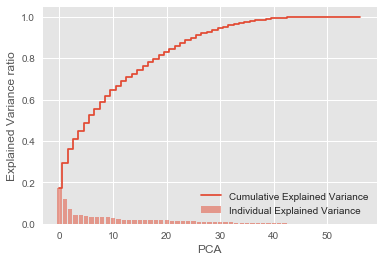

In [64]:
plt.bar(range(57),varianceExplained, alpha=0.5, align = 'center', label = 'Individual Explained Variance')
plt.step(range(57), cumulativeVarianceExplained, where = 'mid', label = 'Cumulative Explained Variance')
plt.ylabel('Explained Variance ratio')
plt.xlabel('PCA')
plt.legend(loc='best')
plt.figure(figsize=(10,10))
plt.show()
plt.close()

In [65]:
### Take Top 30 dimensions, these explain easily around 97% of the variance.
BULKvarianceExplained = [(i/Total) for i in sorted(eigenValues, reverse=True)][:30]
BULKcumulativeVarianceExplained = np.cumsum(BULKvarianceExplained)

In [66]:
print(len(BULKvarianceExplained))
print(len(BULKcumulativeVarianceExplained))

30
30


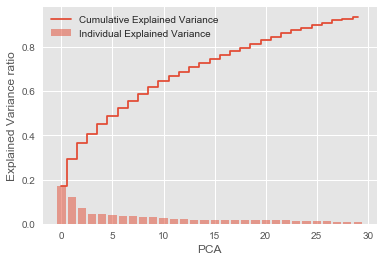

In [67]:
plt.bar(range(30),BULKvarianceExplained, alpha=0.5, align = 'center', label = 'Individual Explained Variance')
plt.step(range(30), BULKcumulativeVarianceExplained, where = 'mid', label = 'Cumulative Explained Variance')
plt.ylabel('Explained Variance ratio')
plt.xlabel('PCA')
plt.legend(loc='best')
plt.show()
plt.close()

### Top 25 Features provide bulk of the information

In [70]:
### Top 25 dimensions, they explain ~ 92% of variance

TOPvarianceExplained = [(i/Total) for i in sorted(eigenValues, reverse=True)][:26]
TOPcumulativeVarianceExplained = np.cumsum(TOPvarianceExplained)

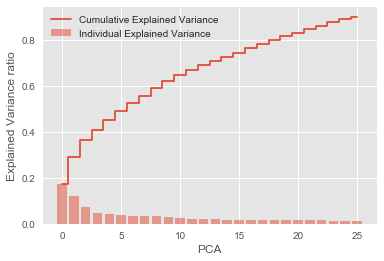

In [72]:
plt.bar(range(26),TOPvarianceExplained, alpha=0.5, align = 'center', label = 'Individual Explained Variance')
plt.step(range(26), TOPcumulativeVarianceExplained, where = 'mid', label = 'Cumulative Explained Variance')
plt.ylabel('Explained Variance ratio')
plt.xlabel('PCA')
plt.legend(loc='best')
plt.show()
plt.close()

In [74]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 

In [76]:
pca = PCA(n_components=25)
analysis = pca.fit_transform(Xtrain_std)

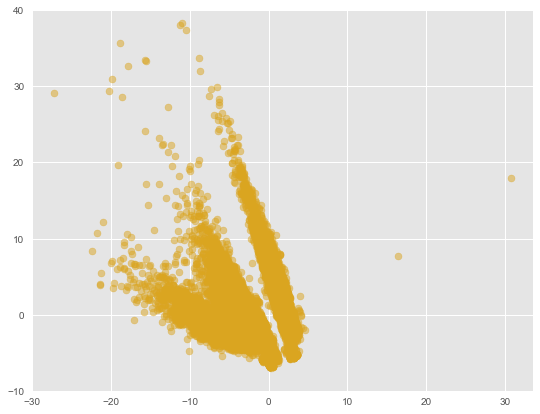

In [109]:
plt.figure(figsize = (9,7))
plt.scatter(analysis[:,0],analysis[:,1], c='goldenrod',alpha=0.5)
plt.ylim(-10,40)
plt.show()
plt.close()

Let's use Kmeans clustering to investigate data

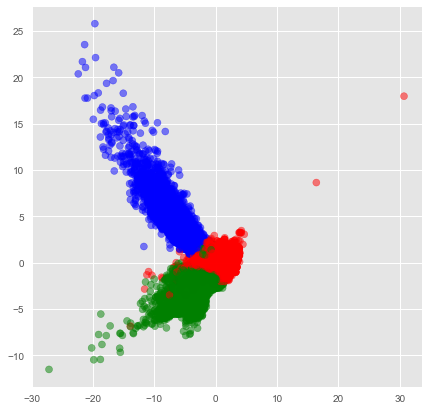

In [110]:
# Set a 3 KMeans clustering
kmeans = KMeans(n_clusters=3)
# Compute cluster centers and predict cluster indices
Xclustered = kmeans.fit_predict(analysis)

# Define our own color map
labelColourMap = {0 : 'r',1 : 'g',2 : 'b'}
labelColour = [labelColourMap[l] for l in Xclustered]

# Plot the scatter diagram
plt.figure(figsize = (7,7))
plt.scatter(analysis[:,0],analysis[:,2], c= labelColour, alpha=0.5) 
plt.show()
plt.close()

https://stats.stackexchange.com/questions/183236/what-is-the-relation-between-k-means-clustering-and-pca

What is the relation between k-means clustering and PCA?

In [94]:
# Create a temp dataframe from our PCA projection data "analysis"
df5 = pd.DataFrame(analysis)
df5 = df5[[0,1,2, 3, 4]] # only want to visualise relationships between first 3 projections
df5['Xcluster'] = Xclustered

c:\users\monika\appdata\local\programs\python\python36\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
c:\users\monika\appdata\local\programs\python\python36\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


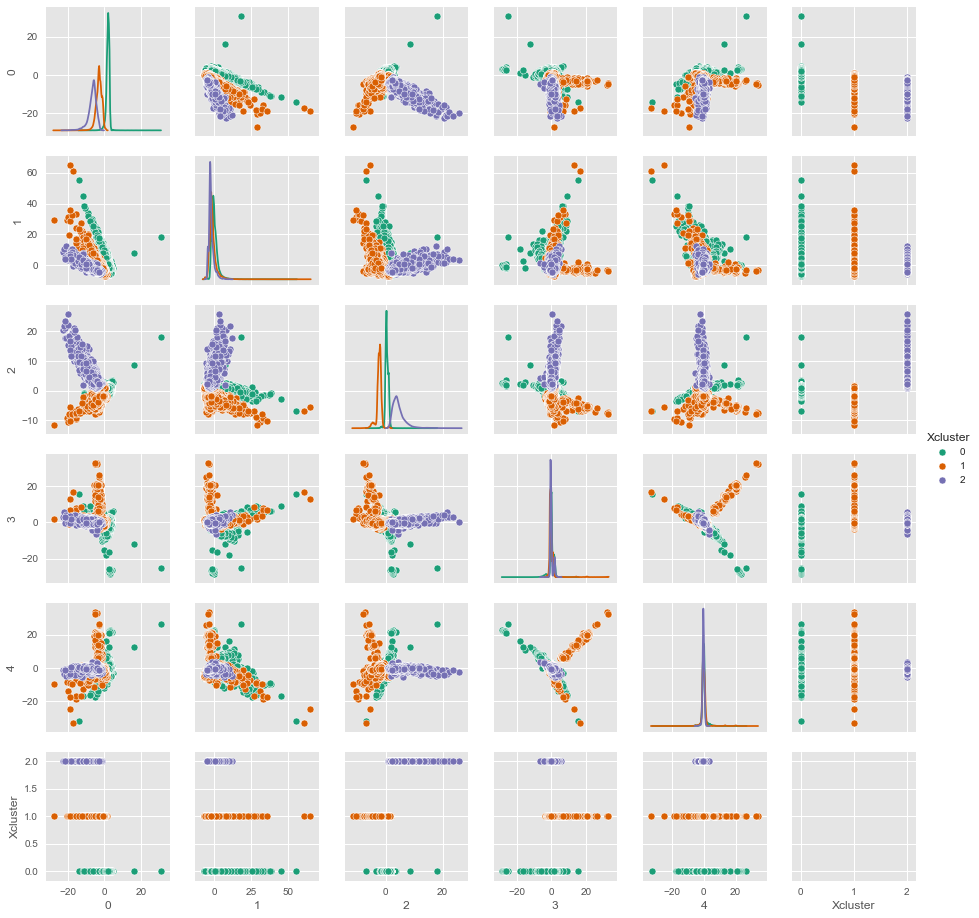

In [96]:
# Call Seaborn's pairplot to visualize our KMeans clustering on the PCA projected data
sn.pairplot(df5, hue='Xcluster', palette= 'Dark2', diag_kind='kde',size=2.15)

In [97]:
# Create a temp dataframe from our PCA projection data "analysis"
df10 = pd.DataFrame(analysis)
df10 = df10[[5, 6, 7, 8, 9]] # only want to visualise relationships between first 3 projections
df10['Xcluster'] = Xclustered

c:\users\monika\appdata\local\programs\python\python36\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
c:\users\monika\appdata\local\programs\python\python36\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


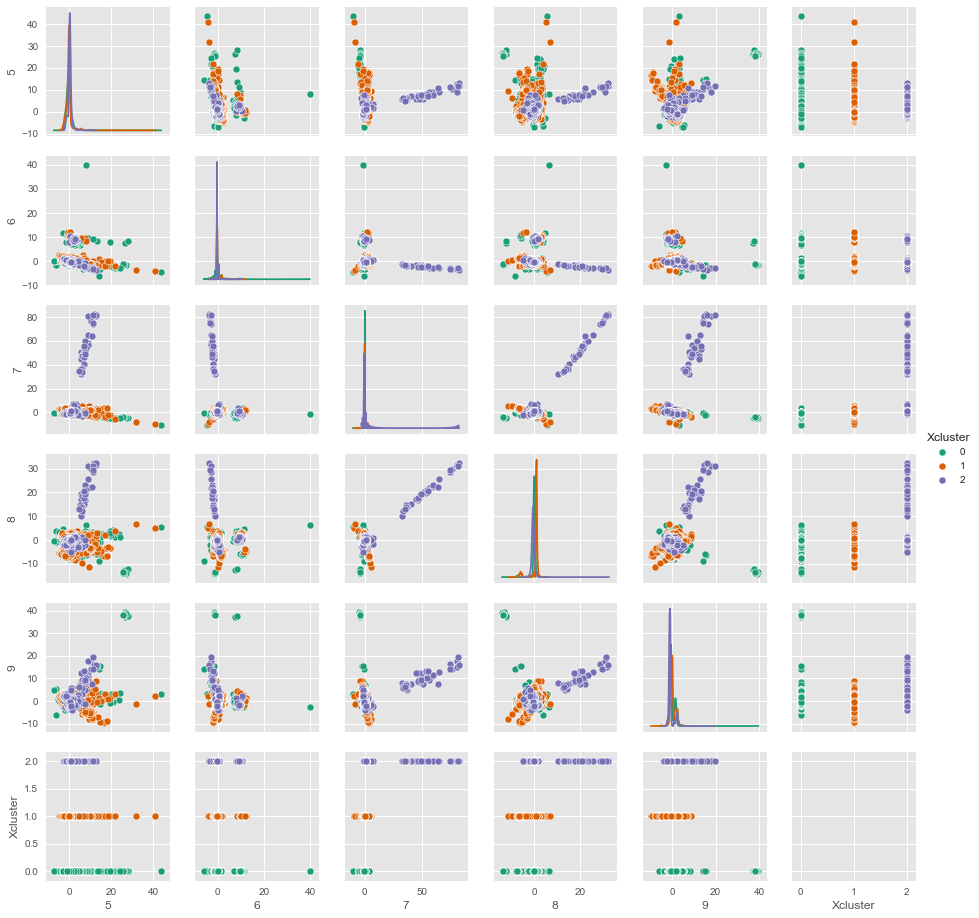

In [101]:
# Call Seaborn's pairplot to visualize our KMeans clustering on the PCA projected data
sn.pairplot(df10, hue='Xcluster', palette= 'Dark2', diag_kind='kde',size=2.15)

In [102]:
# Create a temp dataframe from our PCA projection data "analysis"
df15 = pd.DataFrame(analysis)
df15 = df15[[10, 11, 12, 13, 14]] # only want to visualise relationships between first 3 projections
df15['Xcluster'] = Xclustered

c:\users\monika\appdata\local\programs\python\python36\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
c:\users\monika\appdata\local\programs\python\python36\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


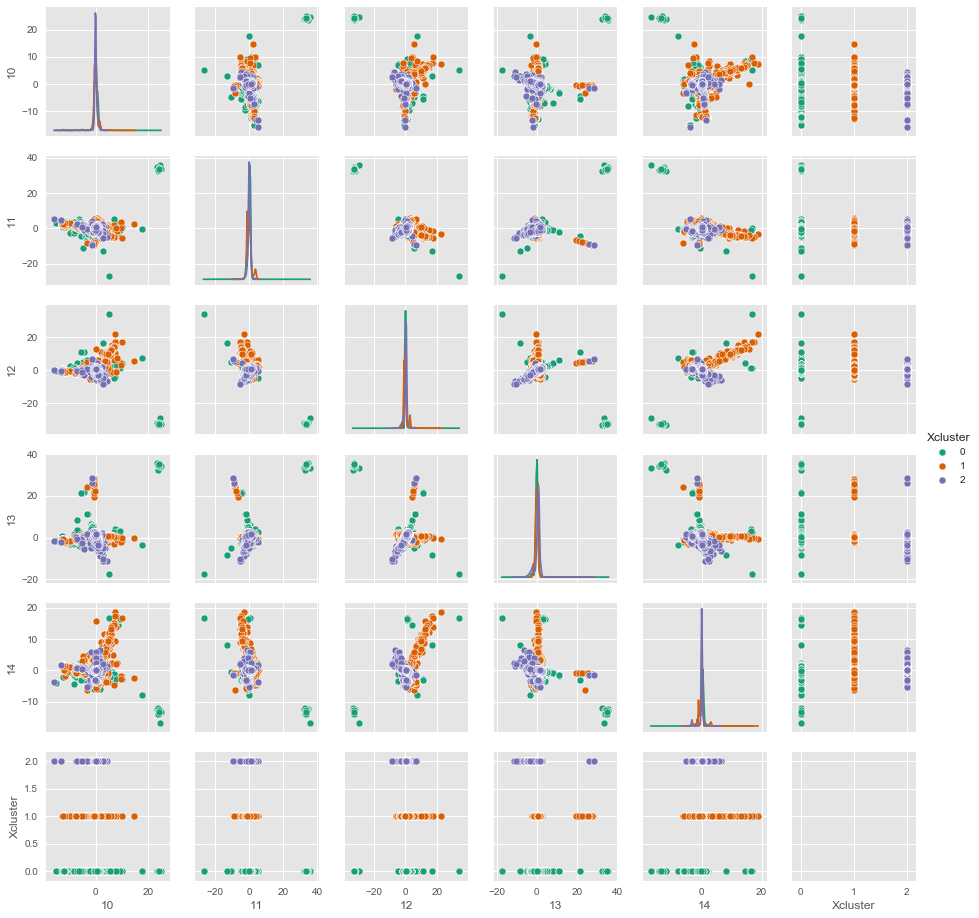

In [103]:
sn.pairplot(df15, hue='Xcluster', palette= 'Dark2', diag_kind='kde',size=2.15)

In [105]:
# Create a temp dataframe from our PCA projection data "analysis"
df20 = pd.DataFrame(analysis)
df20 = df20[[15, 16, 17, 18, 19]] # only want to visualise relationships between first 3 projections
df20['Xcluster'] = Xclustered

c:\users\monika\appdata\local\programs\python\python36\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
c:\users\monika\appdata\local\programs\python\python36\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


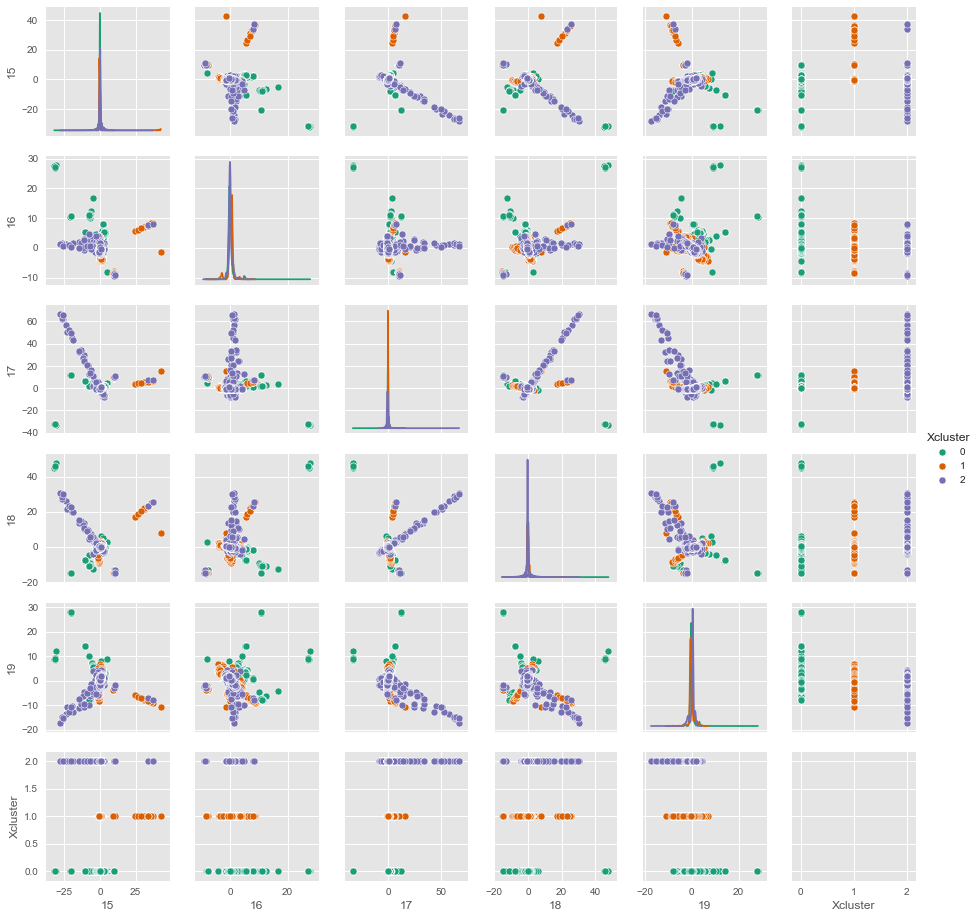

In [106]:
sn.pairplot(df20, hue='Xcluster', palette= 'Dark2', diag_kind='kde',size=2.15)

In [107]:
# Create a temp dataframe from our PCA projection data "analysis"
df25 = pd.DataFrame(analysis)
df25 = df25[[20, 21, 22, 23, 24]] # only want to visualise relationships between first 3 projections
df25['Xcluster'] = Xclustered

c:\users\monika\appdata\local\programs\python\python36\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
c:\users\monika\appdata\local\programs\python\python36\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


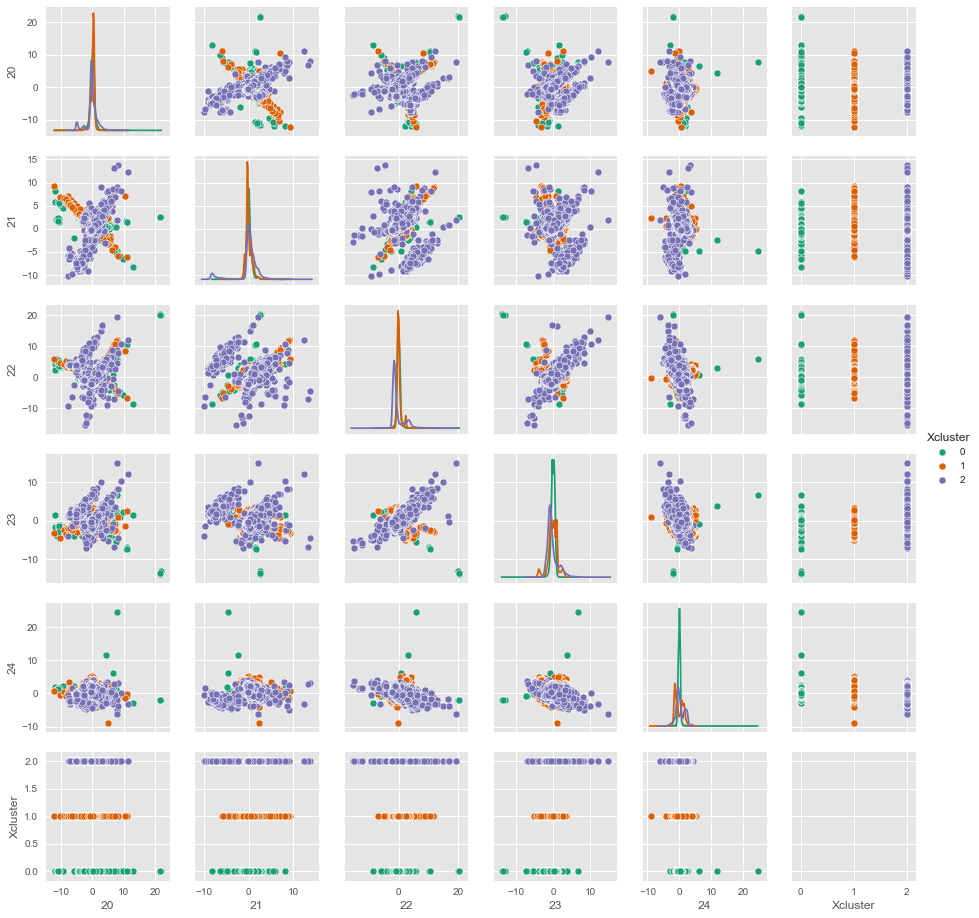

In [108]:
sn.pairplot(df25, hue='Xcluster', palette= 'Dark2', diag_kind='kde',size=2.15)